In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from matplotlib import pyplot
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

In [2]:
FTRAIN = '../../../data/raw/FacialKeyPointDetection/training.csv'
FTEST = '../../../data/raw/FacialKeyPointDetection/test.csv'

In [3]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32) # Copy of the array, cast to a specified type.

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data, random_state corresponding to the seed
        y = y.astype(np.float32) # Copy of the array, cast to a specified type.
    else:
        y = None

    return X, y

In [5]:

X_train, y_train = load()
print("X_train.shape == {}; X_train.min == {:.3f}; X_train.max == {:.3f}".format(
    X_train.shape, X_train.min(), X_train.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [6]:
x1 = tf.placeholder(tf.float32, [None, 9216])
W1 = tf.Variable(tf.zeros([9216, 100]))
W2 = tf.Variable(tf.zeros([100, 30]))
b1 = tf.Variable(tf.zeros([100]))
b2 = tf.Variable(tf.zeros([30]))
y = tf.nn.relu(tf.matmul(x1, W1) + b1)  # the equation
y1 = tf.nn.tanh(tf.matmul(y, W2) + b2)
y_ = tf.placeholder(tf.float32, [None, 30])
mse = tf.reduce_mean(tf.square(tf.subtract(y_, y1)))
train_step = tf.train.AdamOptimizer(0.0001).minimize(mse)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
TRAINING_EPOCHS = 2000

In [13]:
loss = []
avg_loss = []
for j in range(TRAINING_EPOCHS):
    for i in range(20):
        nb = np.array([random.randint(0, len(X_train) - 1) for _ in range(100)])
        batch_xs = X_train[nb]
        batch_ys = y_train[nb]
        _, c = sess.run([train_step, mse], feed_dict={x1: batch_xs, y_: batch_ys})
    loss.append(c)
    avg_loss.append(np.mean(loss))
    if j % 100 == 0:
        print("Epoch " + str(j) + ": loss=", str(np.mean(loss)))
print("done")

Epoch 0: loss= 0.15176494
Epoch 100: loss= 0.101649344
Epoch 200: loss= 0.07183495
Epoch 300: loss= 0.05383527
Epoch 400: loss= 0.042476684
Epoch 500: loss= 0.03505451
Epoch 600: loss= 0.029975114
Epoch 700: loss= 0.026323669
Epoch 800: loss= 0.023583842
Epoch 900: loss= 0.021449165
Epoch 1000: loss= 0.01974634
Epoch 1100: loss= 0.018351162
Epoch 1200: loss= 0.017186092
Epoch 1300: loss= 0.01620615
Epoch 1400: loss= 0.015362336
Epoch 1500: loss= 0.014635929
Epoch 1600: loss= 0.013999555
Epoch 1700: loss= 0.013437564
Epoch 1800: loss= 0.012938655
Epoch 1900: loss= 0.012490043
done


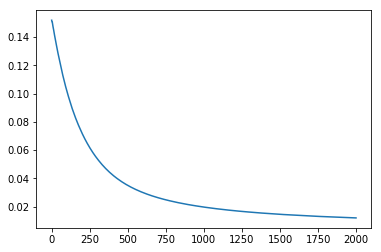

In [14]:
plt.plot(avg_loss)
plt.show()

In [15]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

ImageId    1783
Image      1783
dtype: int64


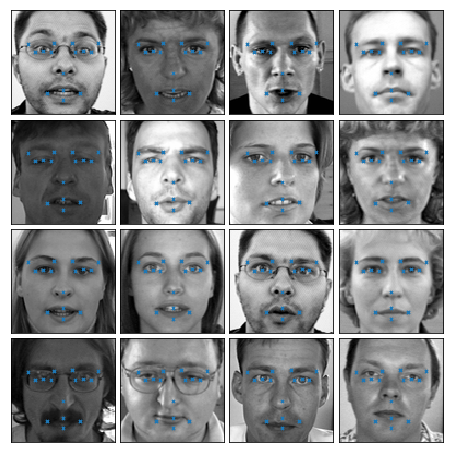

In [16]:
X_test, y = load(True)

classification = sess.run(y1, feed_dict={x1: X_test})
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], classification[i], ax)
plt.show()